In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

from PIL import Image
import matplotlib.pyplot as plt
import numbers
import math

import copy

from pytorch_datasetloader import *

# The Discriminator

In [8]:
#patch level Discriminator Used In cartoonGAN
#code: https://github.com/znxlwm/pytorch-CartoonGAN/
class Dis_patch(nn.Module):
    
    # initializers
    def __init__(self, in_nc, out_nc, nf=32):
        super(Dis_patch, self).__init__()
        self.input_nc = in_nc
        self.output_nc = out_nc
        self.nf = nf
        self.convs = nn.Sequential(
            nn.Conv2d(in_nc, nf, 3, 1, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf * 2, 3, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 2, nf * 4, 3, 1, 1),
            nn.InstanceNorm2d(nf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 4, nf * 4, 3, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 4, nf * 8, 3, 1, 1),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 8, nf * 8, 3, 1, 1),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 8, out_nc, 3, 1, 1),
            nn.Sigmoid(),
        )

    # forward method
    def forward(self, input):

        output = self.convs(input)

        return output

# The Generator

In [9]:
class gen_unet(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(gen_unet, self).__init__()
        # Unet encoder
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv8_bn = nn.BatchNorm2d(d * 8)

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        


        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e7))), 0.5, training=True)
        d1 = torch.cat([d1, e6], 1)
        
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e5], 1)
        
        d3 = self.deconv3_bn(self.deconv3(F.relu(d2)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        
        d4 = torch.cat([d3, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = F.tanh(d8)

        return o

In [10]:
#pooling for downsampling was avoided in favor of strided convolutions
#based on following paper: https://arxiv.org/pdf/1606.03498.pdf
class Gen(nn.Module):
    

    
    def __init__(self):
        
        super().__init__()
        

        self.encode = nn.Sequential(
            
            #encoding 1
            nn.Conv2d(in_channels=3,out_channels=15, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(15),
            
            #encoding 2
            nn.Conv2d(in_channels=15,out_channels=50, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(50),
            
            #encoding 3
            nn.Conv2d(in_channels=50,out_channels=200, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(200)
            
            
        )
        
        
        self.decode = nn.Sequential(
            
            #decoding 1
            nn.ConvTranspose2d(in_channels=200,out_channels=50, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(50),
            
            #decoding 2
            nn.ConvTranspose2d(in_channels=50,out_channels=15, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(15),
            
            #decoding 3
            nn.ConvTranspose2d(in_channels=15,out_channels=3, kernel_size=4, stride=2, padding=1)
        )
        
        
        
        
    def forward(self, x):
        

        out = self.encode(x)
        out = self.decode(out)
  
        return(out)




# Gaussian Smoother

In [11]:
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input, gaussCount=1):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
            gaussCount (int): number of times filters are added
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        
        out = input
        
        for i in range(gaussCount):
            out = self.conv(out, weight=self.weight, groups=self.groups,padding=1)
            
        
        return out

# VGG19 Feature-map Extractor

In [12]:
class VGG19(nn.Module):
    def __init__(self, init_weights=None, feature_mode=False, batch_norm=False, num_classes=1000):
        super(VGG19, self).__init__()
        self.cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        self.init_weights = init_weights
        self.feature_mode = feature_mode
        self.batch_norm = batch_norm
        self.num_clases = num_classes
        self.features = self.make_layers(self.cfg, batch_norm)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if not init_weights == None:
            self.load_state_dict(torch.load(init_weights))

    def make_layers(self, cfg, batch_norm=False):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.feature_mode:
            module_list = list(self.features.modules())
            for l in module_list[1:27]:                 # conv4_4
                x = l(x)
        if not self.feature_mode:
            x = x.view(x.size(0), -1)
            x = self.classifier(x)

        return x

# Initialize Generetor and Discriminator

In [13]:
#using cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# D = Dis()
D = Dis_patch(3,1)
D = D.to(device)

G = Gen()
G = G.to(device)

gausSmoother = GaussianSmoothing(channels=3,kernel_size=5,sigma=1.276)
gausSmoother = gausSmoother.to(device)


VGG = VGG19('Pretrained Models/vgg19-dcbb9e9d.pth',feature_mode=True)
VGG = VGG.to(device)

cuda:0


# Selecting Optimizer 

In [14]:
criterion = nn.BCELoss().to(device)
L1_loss = nn.L1Loss().to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Reconstruction Workload

## Loading Prexisting Generator

In [20]:
batch_size = 50

#G = Gen_res(3,3)
#G.load_state_dict(torch.load('GAN_OUTs/Reconstructing_generator_gen.pkl'))

G = Gen()
G.load_state_dict(torch.load('GAN_OUTs/custom_DCGAN_recon_init_gen.pkl'))
G = G.to(device)


g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


# path = 'RealFaces_400'
# trainloader_nonpixel, validloader_nonpixel = get_loaders(path,batch_size=batch_size)




## Pre-Train Reconstruction Only

In [37]:
num_epochs = 2000
recon_loss_list = []

for epoch in range(num_epochs):
    
    trainiter_nonpixel = iter(trainloader_nonpixel)
    #trainloader_pixel = iter(trainloader_pixel)
    
    for i in range(5):
        
        inputImages, input_lbls = trainiter_nonpixel.next()
        inputImages = inputImages.to(device)

        fake_images = G(inputImages)
        
        inputImages_fmap = VGG((inputImages + 1) / 2)
        G_fmap = VGG((fake_images + 1) / 2)
        
        Recon_loss = 10 * L1_loss(G_fmap, inputImages_fmap.detach())
        
        g_optimizer.zero_grad()
        Recon_loss.backward()
        g_optimizer.step()
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}] Generator Loss: {:.4f}'.format(epoch+1,num_epochs,Recon_loss.item()))
        #appending loss every 10 epochs
        recon_loss_list.append(Recon_loss.item())
    
        if (epoch+1) % 100 == 0:
        # Save fake images
            fake_images = fake_images.view(fake_images.size(0), 3, 128, 128)
            save_image(fake_images.data, 'images/GAN_IO/fakes/fake_images-%d.png' %(epoch+1))



#Save Generator
torch.save(G.state_dict(), 'GAN_OUTs/Reconstructing_generator_gen.pkl')


KeyboardInterrupt: 

## Testing Reconstruction On Different Dataset

In [ ]:
path = 'PixelFaces_400'
im_loader, _ = get_loaders(path,batch_size=batch_size_Realpix,num_workers=0)

testiter = iter(im_loader)

testImages, _ = testiter.next()
testImages = testImages.to(device)


output = G(testImages)

fake_images = output.view(output.size(0), 3, 128, 128)
save_image(fake_images.data, 'images/GAN_IO/sample_outputs/recon_sample.png')

testImages = testImages.view(testImages.size(0), 3, 128, 128)
save_image(testImages.data, 'images/GAN_IO/sample_outputs/recon_input.png')



# DCGAN Training

## Loading Prexisting Generator

In [15]:
# G = Gen_res(3,3)
# G.load_state_dict(torch.load('GAN_OUTs/Reconstructing_generator.pkl'))

G = Gen()
G.load_state_dict(torch.load('GAN_OUTs/custom_DCGAN_recon_init_gen.pkl'))
G = G.to(device)

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


## Loading Datasets for Training DCGAN

In [16]:
batch_size_Realpix = 60
batch_size_mixed = 60
dataset_len =  350

path = 'RealFaces_350'
trainloader_nonpixel, validloader_nonpixel = get_loaders(path,split_perc=1.0,batch_size=batch_size_Realpix)

path = 'PixelFaces_350'
trainloader_pixel, validloader_pixel = get_loaders(path,split_perc=1.0,batch_size=batch_size_mixed)


trainiter_nonpixel = iter(trainloader_nonpixel)
trainIter_pixel = iter(trainloader_pixel)

350 images from the dataset
350 images from the dataset


## Training the DCGAN

In [ ]:
#Patch Version with color loss

# Train the model
total_step = len(trainloader_pixel)
d_loss_list = []
g_loss_list = []
acc_list = []
num_epochs = 2500
sample_imflag = 0
imsize = 128

for epoch in range(num_epochs):
    
    trainiter_nonpixel = iter(trainloader_nonpixel)
    trainIter_pixel = iter(trainloader_pixel)
    
    for i in range(5):
        
        images, lbls = trainIter_pixel.next()
        inputImages, input_lbls = trainiter_nonpixel.next()
        
        
        images = images.to(device)
        inputImages = inputImages.to(device)
        
        labels = torch.ones(len(lbls), 1, imsize // 4 , imsize // 4 ).to(device)
        
        # Run the forward pass
        
        #blurring images before feeding to discriminator
        blurred_images = gausSmoother(images)
        real_classification = D(blurred_images)
        

        fake_images = G(inputImages).detach()
        blurred_fakeimages = gausSmoother(fake_images)
        
        fake_classification = D(blurred_fakeimages)

        fake_lbls = torch.zeros(len(input_lbls), 1, imsize // 4 , imsize // 4 ).to(device)
        
        d_loss_real = criterion(real_classification, labels)
        d_loss_fake = criterion(fake_classification, fake_lbls)
        d_loss = d_loss_real + d_loss_fake
        

        # Backprop and perform Adam optimisation for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        
        #Discriminator
        fake_lbls_duped = torch.ones(len(input_lbls), 1, imsize // 4 , imsize // 4 ).to(device)
        fake_lbls_duped = fake_lbls_duped.to(device)
   
        fake_images = G(inputImages)
        blurred_fakeimages = gausSmoother(fake_images)
        fake_classification = D(blurred_fakeimages)
    
        #this loss denotes how well the generator duped/tricked the discriminator
        g_loss = criterion(fake_classification, fake_lbls_duped)
        
        
        inputImages_fmap = VGG((inputImages + 1) / 2)
        G_fmap = VGG((fake_images + 1) / 2)   
        Recon_loss =  L1_loss(G_fmap, inputImages_fmap.detach())
        
        
        g_loss = 0.5*(g_loss + Recon_loss)
        
        
        # Backprop and perform Adam optimisation for generator
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}] Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(epoch+1,num_epochs,d_loss.item(),g_loss.item()))
        #appending loss every 10 epochs
        d_loss_list.append(d_loss.item())
        g_loss_list.append(g_loss.item())
        
        # Save fake images
        fake_images = fake_images.view(fake_images.size(0), 3, imsize, imsize)
        save_image(fake_images.data, 'images/GAN_IO/fakes/fake_images-%d.png' %(epoch+1))
        
        
        # Save input images
        if sample_imflag == 0:
            inputImages = inputImages.view(inputImages.size(0), 3, imsize, imsize)
            save_image(inputImages.data, 'images/GAN_IO/input_images/inputImages-%d.png' %(epoch+1))
            sample_imflag = 1
    

    


Epoch No [10/2500] Discriminator Loss: 1.0873, Generator Loss: 0.5966
Epoch No [20/2500] Discriminator Loss: 1.0191, Generator Loss: 0.7984
Epoch No [30/2500] Discriminator Loss: 1.1901, Generator Loss: 0.6735
Epoch No [40/2500] Discriminator Loss: 1.1349, Generator Loss: 0.6769
Epoch No [50/2500] Discriminator Loss: 1.1396, Generator Loss: 0.8773
Epoch No [60/2500] Discriminator Loss: 1.3230, Generator Loss: 0.7086
Epoch No [70/2500] Discriminator Loss: 1.1248, Generator Loss: 0.7685
Epoch No [80/2500] Discriminator Loss: 1.0811, Generator Loss: 0.8123
Epoch No [90/2500] Discriminator Loss: 0.8544, Generator Loss: 0.9732
Epoch No [100/2500] Discriminator Loss: 1.2435, Generator Loss: 0.8102
Epoch No [110/2500] Discriminator Loss: 0.9783, Generator Loss: 0.7163
Epoch No [120/2500] Discriminator Loss: 0.8827, Generator Loss: 0.7874
Epoch No [130/2500] Discriminator Loss: 0.9144, Generator Loss: 0.8292
Epoch No [140/2500] Discriminator Loss: 1.0817, Generator Loss: 1.1211
Epoch No [150/2

In [ ]:
#Patch Version 

# Train the model
total_step = len(trainloader_pixel)
d_loss_list = []
g_loss_list = []
acc_list = []
num_epochs = 2500
sample_imflag = 0
imsize = 128

for epoch in range(num_epochs):
    
    trainiter_nonpixel = iter(trainloader_nonpixel)
    trainIter_pixel = iter(trainloader_pixel)
    
    for i in range(5):
        
        images, lbls = trainIter_pixel.next()
        inputImages, input_lbls = trainiter_nonpixel.next()
        
        
        images = images.to(device)
        inputImages = inputImages.to(device)
        
        labels = torch.ones(len(lbls), 1, imsize // 4, imsize // 4).to(device)
        
        # Run the forward pass

        real_classification = D(images)
        

        fake_images = G(inputImages)
        fake_classification = D(fake_images)

        fake_lbls = torch.zeros(len(input_lbls), 1, imsize // 4, imsize // 4).to(device)
        
        d_loss_real = criterion(real_classification, labels)
        d_loss_fake = criterion(fake_classification, fake_lbls)
        d_loss = d_loss_real + d_loss_fake
        

        # Backprop and perform Adam optimisation for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        
        #Discriminator
        fake_lbls_duped = torch.ones(len(input_lbls), 1, imsize // 4, imsize // 4).to(device)
        fake_lbls_duped = fake_lbls_duped.to(device)
   
        fake_images = G(inputImages)
        fake_classification = D(fake_images)
    
        #this loss denotes how well the generator duped/tricked the discriminator
        g_loss = criterion(fake_classification, fake_lbls_duped)
        
        
        inputImages_fmap = VGG((inputImages + 1) / 2)
        G_fmap = VGG((fake_images + 1) / 2)   
        Recon_loss =  L1_loss(G_fmap, inputImages_fmap.detach())
        
        
        g_loss = g_loss + 1.2 * Recon_loss
        
        
        # Backprop and perform Adam optimisation for generator
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}] Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(epoch+1,num_epochs,d_loss.item(),g_loss.item()))
        #appending loss every 10 epochs
        d_loss_list.append(d_loss.item())
        g_loss_list.append(g_loss.item())
        
        # Save fake images
        fake_images = fake_images.view(fake_images.size(0), 3, imsize, imsize)
        save_image(fake_images.data, 'images/GAN_IO/fakes/fake_images-%d.png' %(epoch+1))
        
        
        # Save input images
        if sample_imflag == 0:
            inputImages = inputImages.view(inputImages.size(0), 3, imsize, imsize)
            save_image(inputImages.data, 'images/GAN_IO/input_images/inputImages-%d.png' %(epoch+1))
            sample_imflag = 1
    

    


# DCGAN Training

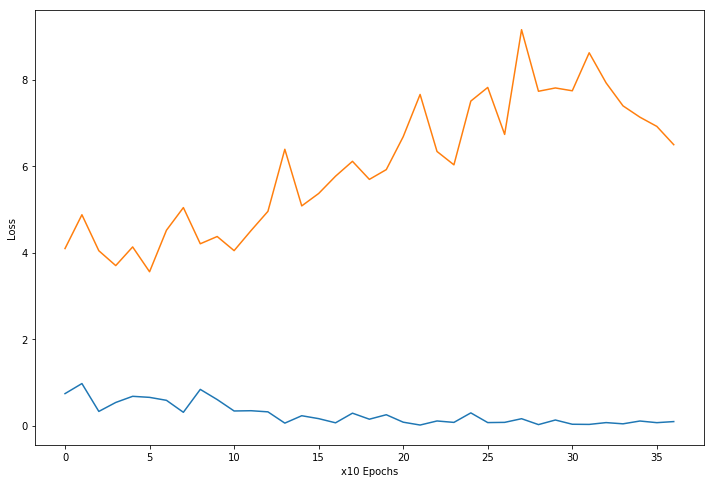

In [13]:
#GANs are saved
torch.save(G.state_dict(), 'GAN_OUTs/DCGANPatch_unet.pkl')
torch.save(D.state_dict(), 'GAN_OUTs/DCGANPatchRes_unet.pkl')

plt.figure(figsize=[12,8])
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.ylabel('Loss')
plt.xlabel('x10 Epochs')
plt.savefig('images/GAN_LOSS_PLOT/GAN_Loss_Unet.png')



In [10]:
G = gen_unet()
G = G.to(device)
G.load_state_dict(torch.load('GAN_OUTs/DCGANPatch_unet.pkl'))


batch_size = 10
path = 'RealFaces_350'
trainloader_pixel, _ = get_loaders(path,split_perc=1.0,batch_size=batch_size,num_workers=0)

testImages = iter(trainloader_pixel).next()

testimg = testImages[0].to(device)
print(testimg.shape)

output = G(testimg)

fake_images = output.view(output.size(0), 3, 128, 128)
f = fake_images.detach().cpu().numpy()
save_image(fake_images.data, 'images/GAN_IO/CustomDCGAN_unet.png')

testImages = testimg.view(testimg.size(0), 3, 128, 128)
t = testImages.detach().cpu().numpy()
save_image(testimg.data, 'images/GAN_IO/CustomDCGAN_unet_input.png')

350 images from the dataset
torch.Size([10, 3, 128, 128])
